In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.gd as gd
import mlgrad.regular as regular
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.1+ (default, Jan 20 2021, 14:49:22) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [4]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= X.mean()
Y -= Y.mean()
# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

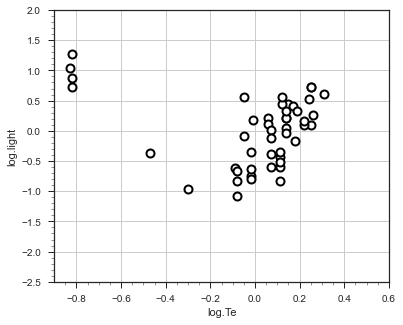

In [5]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.show()

In [6]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [7]:
mod1 = model.LinearModel(1)
mod1.init()

print(np.array(mod1.param))

[0.36016863 0.89290749]


K=1000 param=[0.00086302 0.0526501 ]
Completed? False


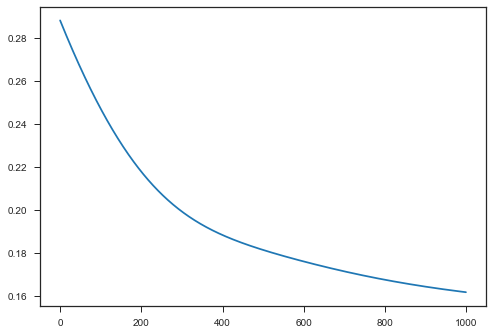

In [8]:
er1 = erisk(Xs, Y, mod1, loss_func_sq)
alg_fg1 = erm_fg(er1, h=0.001, tol=1.0e-6, verbose=1)
print("Completed?", alg_fg1.completed)

plt.plot(alg_fg1.lvals)
plt.show()

In [9]:
mod2 = model.LinearModel(1)
mod2.init()

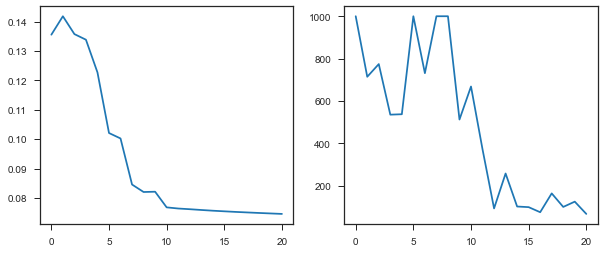

In [10]:
er2 = erisk(Xs, Y, mod2, loss_func_sq)
alg_fg2 = fg(er2, h=0.001, tol=1.0e-9)
avg2 = averager_it(func.Quantile_Sqrt(0.85, 0.001))
avg2 = avragg.WMAverage(avg2)
wg2 = weights.MWeights(avg2, er2)
irgd2 = erm_irgd(alg_fg2, wg2, n_iter=21, tol=1.0e-5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(irgd2.lvals)
plt.subplot(1,2,2)
plt.plot(irgd2.n_iters)
plt.show()
#plt.plot(alg_fg2.lvals)

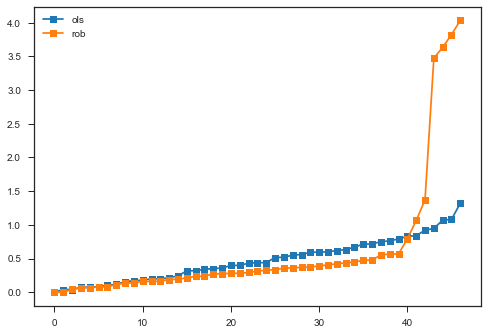

In [11]:
res1 = np.abs(Y - mod1.evaluate_all(Xs))
res1.sort()
res2 = np.abs(Y - mod2.evaluate_all(Xs))
res2.sort()
plt.plot(res1, marker='s', label='ols')
plt.plot(res2, marker='s', label='rob')
plt.legend()
plt.show()

In [12]:
Err = np.abs(Y - mod2.evaluate_all(Xs))

X1, X1_ = array_exclude_outliers(X, Err, 7) 
Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
X1s = X1.reshape(-1,1)

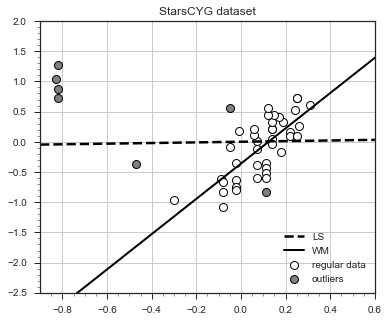

In [13]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
#plt.xlabel('log.Te')
#plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [14]:
mod22 = model.LinearModel(1)
mod22.init()

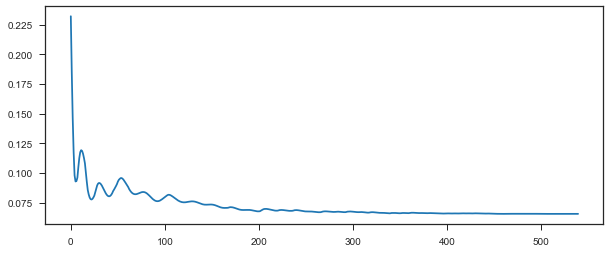

In [15]:
avg22 = averager_it(func.Quantile_Sqrt(0.85, 0.001))
avg22 = avragg.WMAverage(avg22)
mr2 = mrisk(Xs, Y, mod22, loss_func_sq, avg22)
alg_fg2 = fg(mr2, h=0.1, tol=1.0e-7)
alg_fg2.fit()

plt.figure(figsize=(10,4))
plt.plot(alg_fg2.lvals)
plt.show()

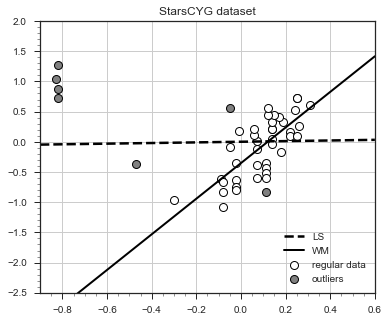

In [16]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod22.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
#plt.xlabel('log.Te')
#plt.ylabel('log.light')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [17]:
mod3 = model.LinearModel(1)
mod3.init()

Completed? True


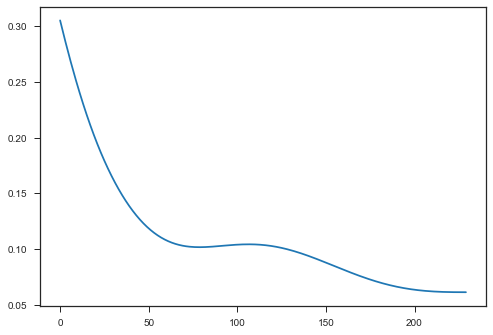

In [18]:
er3 = erisk(X1s, Y1, mod3, loss_func_sq)
alg_fg3 = erm_fg(er3, h=0.01, tol=1.0e-6, verbose=0)
print("Completed?", alg_fg3.completed)

plt.plot(alg_fg3.lvals)
plt.show()

In [19]:
mod4 = model.LinearModel(1)
mod4.init()

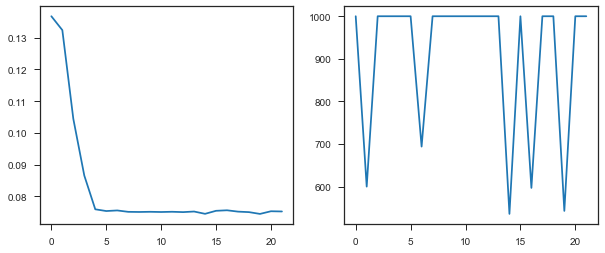

In [20]:
er4 = erisk(Xs, Y, mod4, loss_func_sq)
alg_fg4 = fg(er4, h=0.001, tol=1.0e-9)
avg4 = averager_it(func.QuantileFunc(0.84, func.Sqrt(0.001)))
avg4 = avragg.HMAverage(avg4)
wg4 = weights.MWeights(avg4, er4)
irgd4 = erm_irgd(alg_fg4, wg4, n_iter=22, tol=1.0e-5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(irgd4.lvals)
plt.subplot(1,2,2)
plt.plot(irgd4.n_iters)
plt.show()
# plt.plot(alg_fg2.lvals)

In [21]:
Err = np.abs(Y - mod4.evaluate_all(Xs))

X2, X2_ = array_exclude_outliers(X, Err, 6) 
Y2, Y2_ = array_exclude_outliers(Y, Err, 6) 
X2s = X2.reshape(-1,1)

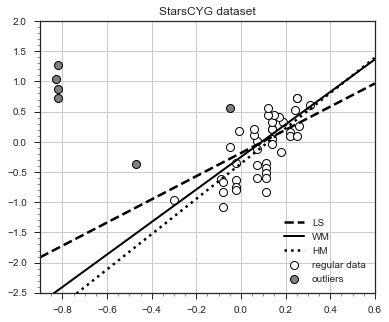

In [22]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X2, Y2, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X2_, Y2_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
X0 = np.linspace(-0.9, 0.6, 20)
plt.plot(X0, mod3.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod4.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), c='k', linestyle=':', linewidth=2.5, label=r'HM')
plt.minorticks_on()
plt.grid(1)
plt.legend(loc='best')
plt.xlim(-0.9, 0.6)
plt.ylim(-2.5, 2.0)
plt.show()

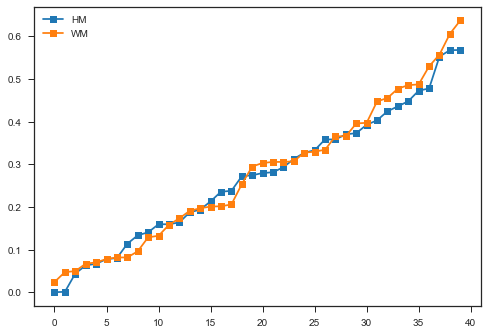

In [23]:
res3 = np.abs(Y1 - mod2.evaluate_all(X1s))
res3.sort()
res4 = np.abs(Y1 - mod4.evaluate_all(X1s))
res4.sort()
plt.plot(res3, marker='s', label='HM')
plt.plot(res4, marker='s', label='WM')
plt.legend()
plt.show()

In [24]:
40/47

0.851063829787234